# Comparison of classifier vs. getSuspects

In [1]:
from truthnet import truthnet
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.stats.api as sms
from tqdm.notebook import tqdm
import tikzplotlib as tpl
from datetime import datetime
from IPython.display import display, HTML
import glob
from zedstat import zedstat

from sklearn.linear_model import LogisticRegression
import lightgbm as lgb
import xgboost as xgb
from sklearn.ensemble import (
    ExtraTreesClassifier,
    RandomForestClassifier,
)
from sklearn.metrics import (
    PrecisionRecallDisplay,
    RocCurveDisplay,
    auc,
    mean_squared_error,
    precision_recall_curve,
    r2_score,
    roc_curve,
    roc_auc_score,
)
from sklearn.model_selection import train_test_split
import optuna

# optuna.logging.set_verbosity(optuna.logging.WARNING)

In [2]:
def _dissonance_data_at_question(dissonances, questions_asked):
    return np.array(
        [np.hstack([d[questions_asked - 1] for d in diss]) for diss in dissonances]
    )


def _diss_dataset(dissonances, questions_asked, groups=["qsampled", "m2"]):
    diss_dataset = pd.concat(
        [
            pd.DataFrame(
                _dissonance_data_at_question(dissonances[group], questions_asked)
            ).assign(y=group)
            for group in groups
        ]
    )
    return diss_dataset

In [3]:
diss = [
    pd.read_pickle(d)
    for d in glob.glob(
        "disson_ptsd/core/disson_ptsd_core_with_actual_random_order_disson*.pkl"
    )
]

samps = [
    pd.read_pickle(d)
    for d in glob.glob(
        "disson_ptsd/core/disson_ptsd_core_with_actual_random_order_samples*.pkl"
    )
]

In [4]:
groups = ["qsampled", "actual"]

questions_asked = 20
_diss_dataset(diss[0], questions_asked, groups=groups)

,0,1,2,3,4,5,6,7,8,9,...,51,52,53,54,55,56,57,58,59,y
0,0.0,0.000000,0.000000,1.000000,0.647059,0.474657,0.112150,0.853659,0.324675,1.000000,...,1.000000,0.736842,0.000000,0.241379,1.000000,0.000000,0.938144,0.000000,0.938144,qsampled
1,0.0,0.725600,0.000000,1.000000,0.000000,0.476991,0.112150,0.958485,0.025974,0.000000,...,0.655914,0.941761,0.000000,0.241379,1.000000,0.978723,0.000000,0.000000,0.337017,qsampled
2,0.0,0.461411,0.000000,0.203704,0.000000,0.745332,0.887850,1.000000,0.000000,0.000000,...,0.537634,0.950943,0.000000,0.241379,0.000000,0.776596,0.618557,0.000000,1.000000,qsampled
3,1.0,0.391356,0.000000,1.000000,0.000000,0.959700,0.588785,0.853659,0.324675,0.974094,...,1.000000,0.000000,1.000000,0.000000,0.915254,0.000000,0.000000,1.000000,0.988950,qsampled
4,0.0,0.391356,0.082353,0.974400,1.000000,0.869197,0.112150,0.853659,0.389610,1.000000,...,0.537634,0.950943,0.857143,0.862069,0.915254,0.000000,0.000000,1.000000,0.983121,qsampled
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299,0.0,0.000000,0.235294,0.203704,0.250000,0.000000,0.000000,0.853659,0.025974,0.955571,...,0.000000,0.669811,0.571429,0.241379,0.915254,0.446809,0.618557,0.000000,0.000000,actual
300,0.9,0.716252,0.235294,1.000000,0.875000,0.606100,0.000000,0.000000,0.311688,0.955571,...,1.000000,0.200000,0.905405,1.000000,0.988889,0.776596,0.000000,0.829545,0.933702,actual
301,0.0,0.461411,0.082353,0.974400,0.647059,0.000000,0.112150,0.991697,0.311688,0.955540,...,0.537634,0.950943,0.857143,0.241379,0.000000,0.446809,0.000000,0.000000,0.842450,actual
302,0.0,0.000000,0.082353,0.974400,0.000000,0.548408,0.112150,0.853659,0.025974,0.951306,...,1.000000,0.669811,0.857143,0.241379,0.915254,0.000000,0.000000,0.000000,0.843162,actual


# Runif case

In [35]:
data

,0,1,2,3,4,5,6,7,8,9,...,624,625,626,627,628,629,630,631,632,y
0,0.225613,0.436632,0.650576,0.360003,0.000000,0.000000,0.000000,0.287914,0.607912,0.172898,...,0.967738,0.245011,0.000000,0.725230,0.000000,0.401260,0.000000,0.000000,0.423327,qsampled
1,0.000000,0.425170,0.291603,0.302048,0.000000,0.664433,0.000000,0.000000,0.000000,0.000000,...,0.822090,0.986314,0.630162,0.728607,0.944191,0.000000,0.636008,0.945044,0.157584,qsampled
2,0.147577,0.450592,0.610885,0.334726,0.000000,0.705420,0.358999,0.186914,0.249631,0.350978,...,0.583730,0.000000,0.099841,0.000000,0.000000,0.433947,0.278376,0.000000,0.000000,qsampled
3,0.348055,0.414828,0.551736,0.284063,0.904422,0.000000,0.195890,0.387687,0.719161,0.286062,...,0.618471,0.908296,0.774895,0.000000,0.949634,0.000000,0.000000,0.000000,0.138482,qsampled
4,0.000000,0.444115,0.369874,0.288704,0.000000,0.000000,0.333370,0.372509,0.588590,0.000000,...,0.973171,0.668865,0.253413,0.943781,0.979946,0.979102,0.771459,0.953032,0.322092,qsampled
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.223320,0.856766,0.503062,0.376868,0.000000,0.664464,0.631085,0.332784,0.713217,0.346624,...,0.799048,0.270329,0.971935,0.000000,0.000000,0.985150,0.941457,0.372822,0.000000,runif
96,0.258295,0.937102,0.449882,0.489741,0.908751,0.000000,0.855269,0.000000,0.866564,0.177775,...,0.637492,0.732496,0.067766,0.938707,0.809309,0.665646,0.994463,0.922158,0.062748,runif
97,0.263225,0.000000,0.379910,0.282974,0.883233,0.454010,0.000000,0.000000,0.000000,0.000000,...,0.813773,0.000000,0.972539,0.720424,0.989255,0.982054,0.758684,0.936264,0.204698,runif
98,0.000000,0.859386,0.248367,0.400075,0.791447,0.736570,0.714406,0.089671,0.473041,0.053076,...,0.978983,0.903768,0.000000,0.954044,0.980854,0.848613,0.770417,0.000000,0.764825,runif


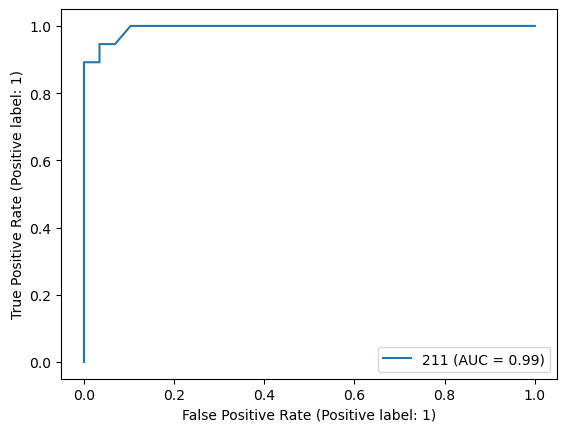

In [36]:
groups = ["qsampled", "runif"]

questions_asked = 211
data = _diss_dataset(diss[0], questions_asked, groups=groups)
X_train, X_test, y_train, y_test = train_test_split(
    data.drop("y", axis="columns"), data["y"], test_size=0.33
)

fig, ax = plt.subplots()

classifier = RandomForestClassifier(n_jobs=-1)

classifier.fit(
    X_train.to_numpy(),
    y_train.replace(
        {
            groups[0]: 0,
            groups[1]: 1,
        }
    ),
)

r = RocCurveDisplay.from_estimator(
    classifier,
    X_test.to_numpy(),
    y_test.replace(
        {
            groups[0]: 0,
            groups[1]: 1,
        }
    ),
    pos_label=1,
    ax=ax,
    name=questions_asked,
)

actual_data = _diss_dataset(diss[0], questions_asked, groups=["actual"])

pred = pd.Series(classifier.predict(actual_data.drop(["y"], axis="columns"))).replace(
    {0: "baseline", 1: groups[1]}
)

pred_prob = pd.Series(
    classifier.predict_proba(actual_data.drop(["y"], axis="columns"))[:, 1],
    name=f"prob_{groups[1]}",
)

m2_prob = (
    pd.concat([actual_data.drop(["y"], axis="columns"), pred_prob], axis="columns")
    .set_index(pd.read_csv("data/ptsd/PTSD_cognet_test.csv")["record_id"])
    .reset_index()
    # .sort_values(by="prob_m2", ascending=False)
)

In [37]:
i = 0
alpha = 0.01

suspects = pd.read_csv(
    f"disson_ptsd/core/disson_ptsd_core_with_actual_random_order_suspects_{i}__{alpha}.csv",
    index_col=0,
)
display(suspects)

display(m2_prob.iloc[suspects.index, :])

print(f"mean {groups[1]} prob: ", m2_prob[f"prob_{groups[1]}"].mean())
print(f"mean {groups[1]} prob (suspects): ", m2_prob.iloc[suspects.index, -1].mean())

,mean_dissonance
9,0.380361
60,0.429343
63,0.401782
86,0.377962
98,0.414350
159,0.384644
188,0.393705
210,0.414758
221,0.394433
222,0.381975


,record_id,0,1,2,3,4,5,6,7,8,...,624,625,626,627,628,629,630,631,632,prob_runif
9,CAT1010,0.222724,0.470746,0.461426,0.391118,0.853921,0.654132,0.358107,0.715585,0.093123,...,0.797281,0.901978,0.765062,0.983556,0.910977,0.976315,0.980769,0.922108,0.462559,0.47
60,CAT1061,0.000000,0.937492,0.342177,0.317518,0.883913,0.647400,0.853793,0.706943,0.504973,...,0.964290,0.985024,0.968884,0.689792,0.673213,0.974136,0.980759,0.922338,0.456629,0.66
63,CAT1064,0.000000,0.855465,0.251000,0.000000,0.000000,0.647985,0.837877,0.713736,0.000000,...,0.964083,0.984721,0.969925,0.983568,1.000000,0.973711,0.982035,0.940935,0.545731,0.64
86,CAT1087,0.000000,0.000000,0.294061,0.000000,0.852041,0.657095,0.386528,0.706429,0.490540,...,0.796303,0.901426,0.512080,0.989019,0.987091,0.974363,0.979682,0.922108,0.461427,0.69
98,CAT1099,0.331542,0.000000,0.000000,0.000000,0.000000,0.000000,0.575328,0.220865,0.490046,...,0.798157,0.889119,0.771860,0.934639,0.984727,0.972120,0.979647,0.936047,0.256827,0.83
159,CAT1160,0.181934,0.000000,0.000000,0.385527,0.855531,0.226969,0.379874,0.205690,0.091445,...,0.974407,0.900898,0.771606,0.990786,0.696664,0.973816,0.981962,0.922108,0.466396,0.87
188,CAT1189,0.169871,0.538743,0.196988,0.000000,0.847225,0.204903,0.594978,0.233915,0.000000,...,0.687374,0.625551,0.781864,0.712688,0.738296,0.972342,0.980790,0.000000,0.522803,0.91
210,CAT1211,0.172690,0.000000,0.000000,0.000000,0.790940,0.237629,0.371947,0.303701,0.095998,...,0.974754,0.984853,0.976904,0.994866,0.984322,0.842126,0.952232,0.923880,0.464810,0.86
221,CAT1222,0.194571,0.000000,0.000000,0.000000,0.889976,0.213457,0.337436,0.772780,0.000000,...,0.964261,0.984532,0.969823,0.983720,1.000000,0.973650,0.981789,0.922108,0.487980,0.77
222,CAT1223,0.277403,0.169435,0.000000,0.000000,0.000000,0.664464,0.247820,0.723376,0.581449,...,0.964112,0.984861,0.981222,0.991332,0.909452,0.000000,0.000000,0.922338,0.000000,0.40


mean runif prob:  0.2098684210526316
mean runif prob (suspects):  0.6881250000000001


# Expert malingering case

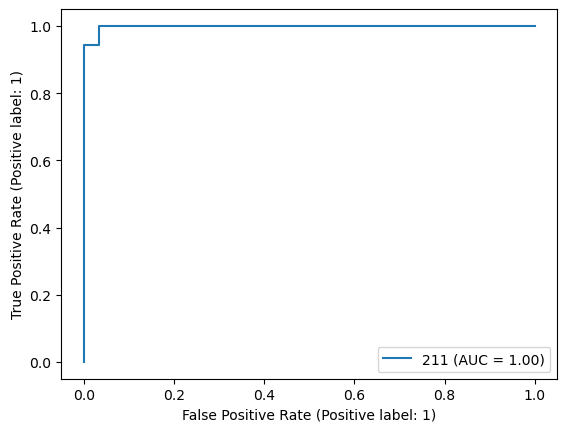

In [39]:
groups = ["qsampled", "m2"]

questions_asked = 211
data = _diss_dataset(diss[0], questions_asked, groups=groups)
X_train, X_test, y_train, y_test = train_test_split(
    data.drop("y", axis="columns"), data["y"], test_size=0.33
)

fig, ax = plt.subplots()

classifier = RandomForestClassifier(n_jobs=-1)

classifier.fit(
    X_train.to_numpy(),
    y_train.replace(
        {
            groups[0]: 0,
            groups[1]: 1,
        }
    ),
)

r = RocCurveDisplay.from_estimator(
    classifier,
    X_test.to_numpy(),
    y_test.replace(
        {
            groups[0]: 0,
            groups[1]: 1,
        }
    ),
    pos_label=1,
    ax=ax,
    name=questions_asked,
)

actual_data = _diss_dataset(diss[0], questions_asked, groups=["actual"])

pred = pd.Series(classifier.predict(actual_data.drop(["y"], axis="columns"))).replace(
    {0: "baseline", 1: groups[1]}
)

pred_prob = pd.Series(
    classifier.predict_proba(actual_data.drop(["y"], axis="columns"))[:, 1],
    name=f"prob_{groups[1]}",
)

m2_prob = (
    pd.concat([actual_data.drop(["y"], axis="columns"), pred_prob], axis="columns")
    .set_index(pd.read_csv("data/ptsd/PTSD_cognet_test.csv")["record_id"])
    .reset_index()
    # .sort_values(by="prob_m2", ascending=False)
)

In [40]:
i = 0
alpha = 0.01

suspects = pd.read_csv(
    f"disson_ptsd/core/disson_ptsd_core_with_actual_random_order_suspects_{i}__{alpha}.csv",
    index_col=0,
)
display(suspects)

display(m2_prob.iloc[suspects.index, :])

print(f"mean {groups[1]} prob: ", m2_prob[f"prob_{groups[1]}"].mean())
print(f"mean {groups[1]} prob (suspects): ", m2_prob.iloc[suspects.index, -1].mean())

,mean_dissonance
9,0.380361
60,0.429343
63,0.401782
86,0.377962
98,0.414350
159,0.384644
188,0.393705
210,0.414758
221,0.394433
222,0.381975


,record_id,0,1,2,3,4,5,6,7,8,...,624,625,626,627,628,629,630,631,632,prob_m2
9,CAT1010,0.222724,0.470746,0.461426,0.391118,0.853921,0.654132,0.358107,0.715585,0.093123,...,0.797281,0.901978,0.765062,0.983556,0.910977,0.976315,0.980769,0.922108,0.462559,0.11
60,CAT1061,0.000000,0.937492,0.342177,0.317518,0.883913,0.647400,0.853793,0.706943,0.504973,...,0.964290,0.985024,0.968884,0.689792,0.673213,0.974136,0.980759,0.922338,0.456629,0.06
63,CAT1064,0.000000,0.855465,0.251000,0.000000,0.000000,0.647985,0.837877,0.713736,0.000000,...,0.964083,0.984721,0.969925,0.983568,1.000000,0.973711,0.982035,0.940935,0.545731,0.10
86,CAT1087,0.000000,0.000000,0.294061,0.000000,0.852041,0.657095,0.386528,0.706429,0.490540,...,0.796303,0.901426,0.512080,0.989019,0.987091,0.974363,0.979682,0.922108,0.461427,0.08
98,CAT1099,0.331542,0.000000,0.000000,0.000000,0.000000,0.000000,0.575328,0.220865,0.490046,...,0.798157,0.889119,0.771860,0.934639,0.984727,0.972120,0.979647,0.936047,0.256827,0.06
159,CAT1160,0.181934,0.000000,0.000000,0.385527,0.855531,0.226969,0.379874,0.205690,0.091445,...,0.974407,0.900898,0.771606,0.990786,0.696664,0.973816,0.981962,0.922108,0.466396,0.09
188,CAT1189,0.169871,0.538743,0.196988,0.000000,0.847225,0.204903,0.594978,0.233915,0.000000,...,0.687374,0.625551,0.781864,0.712688,0.738296,0.972342,0.980790,0.000000,0.522803,0.11
210,CAT1211,0.172690,0.000000,0.000000,0.000000,0.790940,0.237629,0.371947,0.303701,0.095998,...,0.974754,0.984853,0.976904,0.994866,0.984322,0.842126,0.952232,0.923880,0.464810,0.11
221,CAT1222,0.194571,0.000000,0.000000,0.000000,0.889976,0.213457,0.337436,0.772780,0.000000,...,0.964261,0.984532,0.969823,0.983720,1.000000,0.973650,0.981789,0.922108,0.487980,0.06
222,CAT1223,0.277403,0.169435,0.000000,0.000000,0.000000,0.664464,0.247820,0.723376,0.581449,...,0.964112,0.984861,0.981222,0.991332,0.909452,0.000000,0.000000,0.922338,0.000000,0.15


mean m2 prob:  0.5206578947368421
mean m2 prob (suspects):  0.09625
